# Explaining optimisation results (spatial)

This notebook put in relation the data between optimisation weights and learning rates.

In [1]:
import nbhelper
import nbimports
from nbimports import *

In [2]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False, nb_workers=6)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# constants

In [3]:
n_bootstrap = 100

In [4]:
SAVEFIG = False

# load data

In [5]:
nbhelper = reload(nbhelper)

In [6]:
users, templates, annotations, A, B = nbhelper.load_data()

In [7]:
user_list = list(range(1, 13))

In [8]:
users_select = select(users, gesture=1, user=user_list)
annotations_select = select(annotations, user=user_list)

In [9]:
# align IMUS axis to position axis
users_select = users_select.rename(columns={"ax": "ay", "ay": "az", "az": "ax", 
                                            "ax0": "ay0", "ay0": "az0", "az0": "ax0", 
                                            "gx": "gy", "gy": "gz", "gz": "gx",
                                            "gx0": "gy0", "gy0": "gz0", "gz0": "gx0",})

templates = templates.rename(columns={"ax": "ay", "ay": "az", "az": "ax", 
                                      "ax0": "ay0", "ay0": "az0", "az0": "ax0", 
                                      "gx": "gy", "gy": "gz", "gz": "gx",
                                      "gx0": "gy0", "gy0": "gz0", "gz0": "gx0",})

In [10]:
import correlations_app as capp
capp = reload(capp)

# optimisation

In [11]:
run_id = "43e4c89d168f444393e9173f46bfffef"

In [12]:
report, params = nbhelper.get_report_params_from_runid(run_id, report_name="report.csv")

In [13]:
dimensions = eval(params['data.dims'])

In [14]:
dimensions = ['ax0','ay0','az0','gx0','gy0','gz0','px0','py0','pz0','px1','py1','pz1','px2','py2','pz2']

In [15]:
n_dims = len(dimensions)

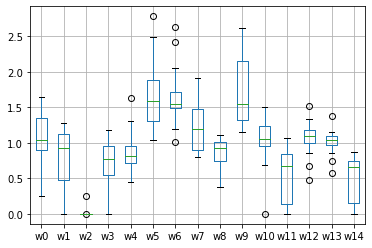

In [16]:
report.filter(regex="w.*").boxplot();

In [17]:
col_dict = capp.colors_dimensions(dimensions)

# learning rate

In [18]:
compute_mse_spatial = capp.compute_mse_spatial(users_select, templates, dimensions)

In [19]:
%%time
mse_s = users_select.groupby(['user', 'day', 'gesture', 'trial']).parallel_apply(compute_mse_spatial)

CPU times: user 173 ms, sys: 80.6 ms, total: 254 ms
Wall time: 4.28 s


In [20]:
mse_s = capp.format_mse_spatial(mse_s, n_dims)

In [21]:
mse_s_plot = mse_s[[str(i) for i in range(15)]+['x', 'user']]
mse_s_plot.columns = dimensions + ['x', 'user']
mse_s_plot = mse_s_plot.melt(id_vars=['x', 'user'], value_vars=dimensions)
row_order = list(np.array(dimensions).reshape(5, 3).T.reshape(-1))

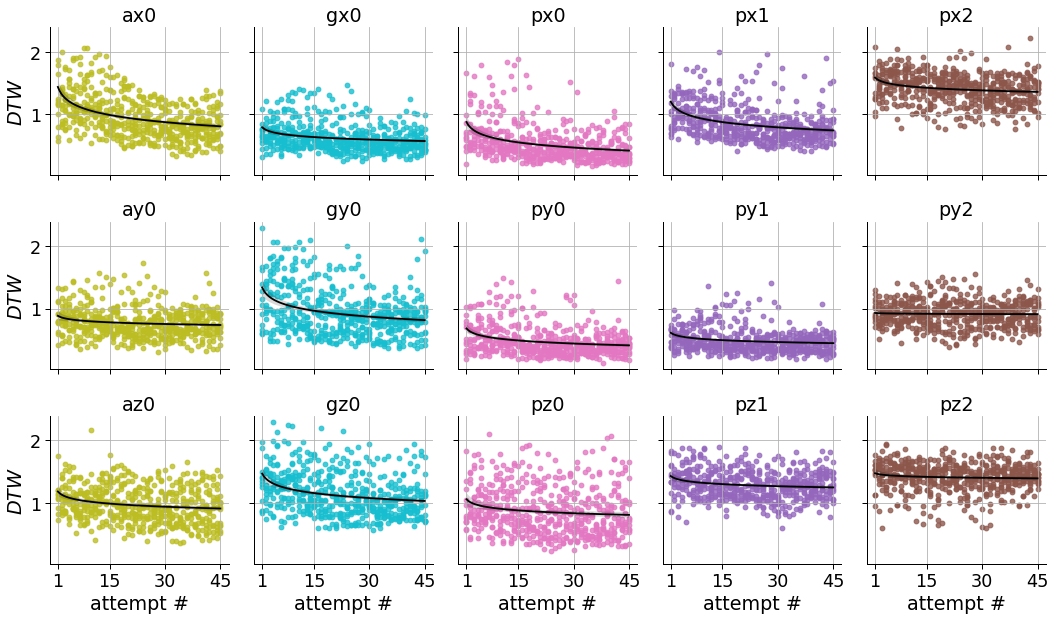

In [22]:
sns.set_context("paper", font_scale=2)

g = sns.FacetGrid(mse_s_plot, col="variable", col_wrap=5, col_order=row_order, hue="variable", palette=col_dict)
g.map(sns.regplot, 'x', 'value', logx=True, line_kws={"color": "black"})

# styling
g.set_titles(col_template = '{col_name}')
g.set_axis_labels("attempt #", "$DTW$")

# mse_s_lr.groupby("variable")["p"].agg(lambda x: (x < 0.01).all())
for axis in g.axes:
    axis.grid()
    axis.set_xticks([1, 15, 30, 45])
#     if axis.get_title() in ['ax0','ay0','px2','py0','py1','py2','pz0','pz1','pz2']:
#         axis.set_facecolor((0.0, 0.0, 0.0, 0.1))

if SAVEFIG:
    g.fig.tight_layout()
    g.fig.savefig("./figs/spatial_learningrate.pdf")

In [23]:
def compute_learningrate_bootstrap(grp):
    res = []
    for fold_id in range(n_bootstrap):
        data = grp.sample(n=len(grp), replace=True)
        lm = pg.linear_regression(np.log(data['x']), data['value'])
        tmp = lm.iloc[1][['coef', 'pval']].values
        res.append([fold_id, *tmp])
        
    res = pd.DataFrame(res, columns=["fold", "B", "p"])
    
    return res

In [24]:
%%time
# fun = compute_learningrate_rkf
fun = compute_learningrate_bootstrap
mse_s_lr = mse_s_plot.groupby("variable").apply(fun)

CPU times: user 11.5 s, sys: 200 ms, total: 11.7 s
Wall time: 1.95 s


In [25]:
mse_s_lr = mse_s_lr.reset_index()

# together

In [26]:
tab10 = sns.color_palette("tab10")

In [27]:
weights = report.filter(regex="w.*")
weights.columns = eval(params['data.dims'])
weights = weights.rename(columns={"ax0": "ay0", "ay0": "az0", "az0": "ax0", 
                                  "gx0": "gy0", "gy0": "gz0", "gz0": "gx0",})
weights = weights.reindex(dimensions, axis=1)

In [28]:
xticklabels = ["${}_{}$".format(sensor, axis) for sensor in ["acc", "gyr", "p0", "p1", "p2"] for axis in "xyz"]

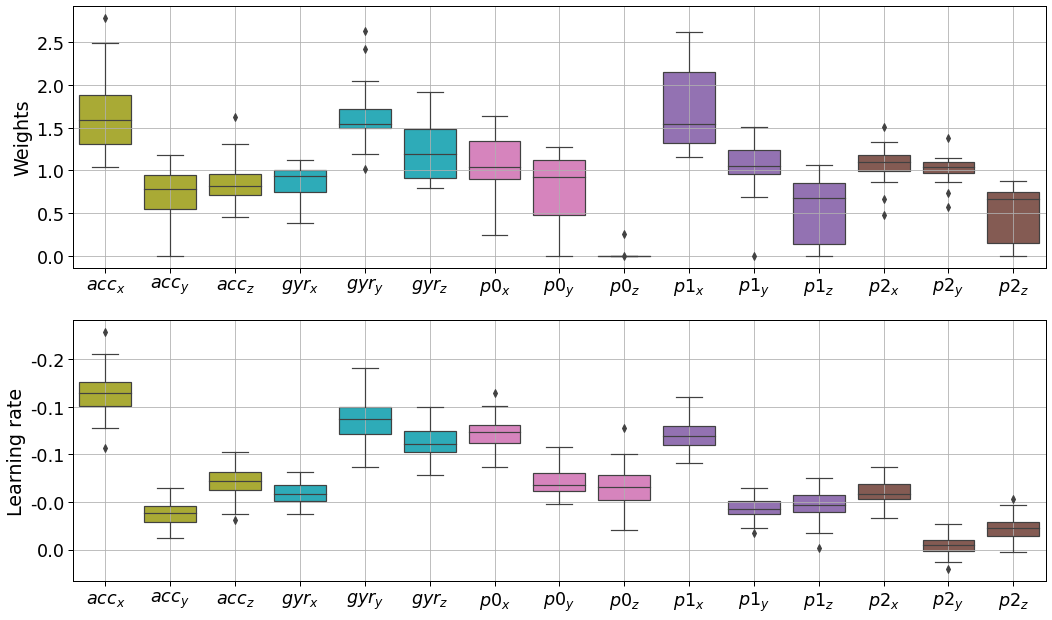

In [29]:
sns.set_context("paper", font_scale=2)

fig, axs = plt.subplots(2, 1, figsize=(15,9))

ALPHA = 0.1

# weights
ax = axs[0]
bp = sns.boxplot(data=weights, palette=col_dict, order=dimensions, ax=ax)
ax.set_ylabel("Weights")
ax.set_xticklabels(xticklabels)

# learning rate
ax = axs[1]
bp = sns.boxplot(data=mse_s_lr, x="variable", y="B", palette=col_dict, order=dimensions, ax=ax)
ax.invert_yaxis()
ax.set_ylabel("Learning rate")
ax.set_xticklabels(xticklabels)


from matplotlib.ticker import FormatStrFormatter
for axis in axs: 
    axis.grid()
    axis.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axis.set_xlabel("")

fig.tight_layout()
if SAVEFIG:
    fig.savefig("./figs/spatial_boxplots.pdf")


# data analysis

In [30]:
weights["pz0"].mean()

0.01581373098330943

## anova 

In [31]:
weights_no_z = weights[['ax0', 'ay0', 'az0', 'gx0', 'gy0', 'gz0', 'px0', 'py0', 'px1', 'py1', 'px2', 'py2']]
weights_no_z = weights_no_z.melt()

In [32]:
data = weights.melt()

In [33]:
data.anova(between="variable", dv="value")

,Source,ddof1,ddof2,F,p-unc,np2
0,variable,14,225,29.918814,1.128469e-43,0.650547


In [34]:
ptt = weights_no_z.pairwise_ttests(between="variable", dv="value", padjust="holm")
ptt_pos = ptt[ptt["p-corr"] < 0.05]

In [35]:
ptt_pos

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,variable,ax0,ay0,False,True,6.371235,30.0,two-sided,4.963707e-07,0.000030,holm,2.258e+04,2.195784
1,variable,ax0,az0,False,True,5.469196,30.0,two-sided,6.193856e-06,0.000334,holm,2367.868,1.884905
2,variable,ax0,gx0,False,True,5.869725,30.0,two-sided,2.007818e-06,0.000114,holm,6439.577,2.022944
5,variable,ax0,px0,False,True,3.822087,30.0,two-sided,6.211277e-04,0.026087,holm,45.743,1.317245
7,variable,ax0,px2,False,True,4.270781,30.0,two-sided,1.805539e-04,0.008125,holm,128.082,1.471883
8,variable,ax0,py0,False,True,5.336116,30.0,two-sided,9.016600e-06,0.000478,holm,1700.606,1.839041
9,variable,ax0,py1,False,True,4.246128,30.0,two-sided,1.933648e-04,0.008508,holm,120.892,1.463387
10,variable,ax0,py2,False,True,4.921356,30.0,two-sided,2.908746e-05,0.001454,holm,611.18,1.696097
13,variable,ay0,gy0,False,True,-7.060131,30.0,two-sided,7.538807e-08,0.000005,holm,1.251e+05,-2.433205
14,variable,ay0,gz0,False,True,-4.281321,30.0,two-sided,1.753354e-04,0.008065,holm,131.291,-1.475516


In [36]:
mse_s_lr.anova(between="variable", dv="B")

,Source,ddof1,ddof2,F,p-unc,np2
0,variable,14,1485,1035.062944,0.0,0.907047


## correlation

In [37]:
lr_mean = mse_s_lr.groupby("variable")["B"].mean()

In [38]:
wg_mean = weights.mean().values

In [39]:
pg.corr(lr_mean, wg_mean)

,n,r,CI95%,p-val,BF10,power
pearson,15,-0.621581,"[-0.86, -0.16]",0.013373,5.219,0.735418
